In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [118]:
csv_data = pd.read_csv("data/YF_IBM.csv")
data = csv_data.loc[:, ["Date", "Adj Close"]]

In [119]:
def split_indices(data, train_size, val_size):
    train_idx = int(train_size * data.shape[0])
    val_idx = int((train_size + val_size) * data.shape[0])
    return train_idx, val_idx

In [120]:
def make_stationary(data):
    diffed = data.copy()
    diffed = data.diff()
    return diffed

def inverse_stationary(original, yhat):
    return yhat.to_numpy() + original.loc[:-1].to_numpy()

In [121]:
def scale(data, avail_idx, scaler):
    scaler.fit(data[:avail_idx])
    return scaler.transform(data)

def unscale(data, scaler):
    return scaler.inverse_transform(data)

In [122]:
train_size = 0.7
val_size = 0.15
train_idx, val_idx = split_indices(data, train_size, val_size)

data.loc[:, "Adj Close"] = make_stationary(data["Adj Close"])
data = data.dropna()
scaler = MinMaxScaler((-1, 1))
data["Adj Close"] = scale(data["Adj Close"].to_numpy().reshape((-1, 1)), val_idx, scaler=scaler)
data

,Date,Adj Close
1,2000-01-04,-0.062858
2,2000-01-05,0.327201
3,2000-01-06,0.033109
4,2000-01-07,0.107409
5,2000-01-10,0.355060
...,...,...
6159,2024-06-27,0.034301
6160,2024-06-28,0.333670
6161,2024-07-01,0.338470
6162,2024-07-02,0.343266


In [137]:
def sequence(data, seq_len, batch_sz):
    x = data[:-seq_len].to_numpy(dtype=np.float32).reshape((-1, 1))
    y = data[seq_len:].to_numpy(dtype=np.float32).reshape((-1, 1))
    ds = timeseries_dataset_from_array(
        x, 
        y, 
        sequence_length=seq_len,
        batch_size=batch_sz
    )
    return ds

In [138]:
seq_len = 20
batch_sz = 16
drop_remain = True

train_ds = sequence(data["Adj Close"][:train_idx], seq_len, batch_sz)
val_ds = sequence(data["Adj Close"][train_idx+1:val_idx], seq_len, batch_sz)

In [139]:
for batch in train_ds.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (16, 20, 1)
Target shape: (16, 1)


2024-07-26 16:46:25.090107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [147]:
lstm_hparams = {
    "units" : [32, 64],
    "activation" : ["relu", "relu"],
    "return_sequences" : [True, False],
    "recurrent_activation" : ["sigmoid", "sigmoid"],
    "dropout" : [0.4, 0.5],
    "recurrent_dropout" : [0., 0.],
    "stateful" : [False, False],
}

inputs = layers.Input(
    shape=(inputs.shape[1], inputs.shape[2]), 
    batch_size=batch_sz, 
    name="Inputs"
)
lstm_1 = layers.LSTM(
    lstm_hparams["units"][0], 
    activation=lstm_hparams["activation"][0], 
    return_sequences=lstm_hparams["return_sequences"][0],
    recurrent_activation=lstm_hparams["recurrent_activation"][0],
    dropout=lstm_hparams["dropout"][0],
    recurrent_dropout=lstm_hparams["recurrent_dropout"][0],
    stateful=lstm_hparams["stateful"][0],
    name="LSTM_1"
)(inputs)
lstm_2 = layers.LSTM(
    lstm_hparams["units"][1], 
    activation=lstm_hparams["activation"][1], 
    return_sequences=lstm_hparams["return_sequences"][1],
    recurrent_activation=lstm_hparams["recurrent_activation"][1],
    dropout=lstm_hparams["dropout"][1],
    recurrent_dropout=lstm_hparams["recurrent_dropout"][1],
    stateful=lstm_hparams["stateful"][1],
    name="LSTM_2"
)(lstm_1)
output = layers.Dense(1, name="Output")(lstm_2)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)             │ (16, 20, 1)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (16, 20, 32)           │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (16, 64)               │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (16, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,249 (114.25 KB)

 Trainable params: 29,249 (114.25 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
chkpt_path = "model_checkpoint.weights.keras"
es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
chkpt_cb = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=chkpt_path,
    verbose=1,
    save_best_only=True
)

In [149]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es_cb, chkpt_cb],
)

Epoch 1/50
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143
Epoch 1: val_loss improved from inf to 0.02670, saving model to model_checkpoint.weights.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0142 - val_loss: 0.0267
Epoch 2/50
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 2: val_loss did not improve from 0.02670
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0268
Epoch 3/50
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 3: val_loss did not improve from 0.02670
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0269
Epoch 4/50
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 4: val_loss did not improve from 0.02670
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0268
Epoch 5/50
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 5: val_loss did not improve from 0.02670
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0267
Epoch 

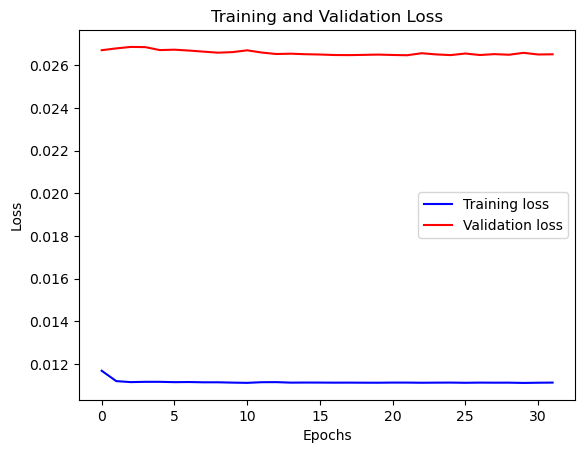

In [150]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")